# Capstone 2 Modeling

In [56]:
import pandas as pd
import numpy as np
import xgboost as xg
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
#import warnings
#warnings.filterwarnings('ignore')



In [57]:
codon_list = ['UUU', 'UUC', 'UUA', 'UUG', 'CUU', 'CUC', 'CUA', 'CUG',
       'AUU', 'AUC', 'AUA', 'AUG', 'GUU', 'GUC', 'GUA', 'GUG', 'GCU', 'GCC',
       'GCA', 'GCG', 'CCU', 'CCC', 'CCA', 'CCG', 'UGG', 'GGU', 'GGC', 'GGA',
       'GGG', 'UCU', 'UCC', 'UCA', 'UCG', 'AGU', 'AGC', 'ACU', 'ACC', 'ACA',
       'ACG', 'UAU', 'UAC', 'CAA', 'CAG', 'AAU', 'AAC', 'UGU', 'UGC', 'CAU',
       'CAC', 'AAA', 'AAG', 'CGU', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG', 'GAU',
       'GAC', 'GAA', 'GAG', 'UAA', 'UAG', 'UGA']

amino_list = ['alanine', 'arginine',
       'asparagine', 'aspartic acid', 'cysteine', 'glutamine', 'glutamic acid',
       'glycine', 'histidine', 'isoleucine', 'leucine', 'lysine', 'methionine',
       'phenylalanine', 'proline', 'serine', 'threonine', 'tryptophan',
       'tyrosine', 'valine', 'start', 'stop']

In [58]:
dnacols = ['D_chloroplast', 'D_genomic', 'D_mitochondrial']
kingcols = ['K_bacteria', 'K_virus', 'K_plant', 'K_vertebrate', 'K_invertebrate',
            'K_mammal', 'K_bacteriophage', 'K_rodent', 'K_primate', 'K_archaea']


In [59]:
# importing the csv from the preprocessing notebook
cu = pd.read_csv('codon_usage3.csv')
cu.head()

,Unnamed: 0,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,...,K_invertebrate,K_mammal,K_plant,K_primate,K_rodent,K_vertebrate,K_virus,D_chloroplast,D_genomic,D_mitochondrial
0,0,virus,genomic,100217,-0.108063,Epizootic haematopoietic necrosis virus,-0.468279,-0.984617,-0.973734,-1.141636,...,0,0,0,0,0,0,1,0,1,0
1,1,virus,genomic,100220,-0.108785,Bohle iridovirus,0.139840,-0.851972,-0.964991,-0.788651,...,0,0,0,0,0,0,1,0,1,0
2,2,virus,genomic,100755,-0.104089,Sweet potato leaf curl virus,-0.284696,-0.143098,-0.338885,0.145086,...,0,0,0,0,0,0,1,0,1,0
3,3,virus,genomic,100880,-0.108174,Northern cereal mosaic virus,-0.398861,-0.087111,-0.211624,-0.449699,...,0,0,0,0,0,0,1,0,1,0
4,4,virus,genomic,100887,-0.079183,Soil-borne cereal mosaic virus,0.198357,-0.839913,-0.625466,2.450823,...,0,0,0,0,0,0,1,0,1,0


In this notebook I'm going to prepare and evaluate several different models.  Each model will be run across a range of hyperparameter values.  Also, each model will be applied to 4 sets of outcome and predictor variables.  I'll predict DNAtype based on amino acids, DNAtype based on codons, kingdom based on amino acids, and kingdom based on codons.  Incorporating both the amino acid and codon data in a single model would be unwarranted, as the amino acid frequencies are linear combinations of the codon frequencies.

### K-Nearest Neighbors

In [6]:
# predicting DNA on codon

y = cu[dnacols]
X = cu[codon_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1331)

test_scores = []
train_scores = []

for i in range(1,11):

    knn = KNeighborsClassifier(i)
    knn.fit(X_train,y_train)
    
    train_scores.append(knn.score(X_train,y_train))
    test_scores.append(knn.score(X_test,y_test))

for i in range(len(test_scores)):
    print("K =", i+1, "train score:", train_scores[i], "test score:", test_scores[i])

K = 1 train score: 0.9998897950187349 test score: 0.9940858832604783
K = 2 train score: 0.9948203658805378 test score: 0.9897145795834404
K = 3 train score: 0.9973550804496363 test score: 0.9933144767292363
K = 4 train score: 0.994269340974212 test score: 0.9910002571355104
K = 5 train score: 0.9958122107119242 test score: 0.9920287991771664
K = 6 train score: 0.9936081110866212 test score: 0.9907431216250965
K = 7 train score: 0.9950407758430682 test score: 0.9912573926459244
K = 8 train score: 0.9933877011240908 test score: 0.9892003085626125
K = 9 train score: 0.9943795459554772 test score: 0.9907431216250965
K = 10 train score: 0.9926162662552347 test score: 0.9889431730521985


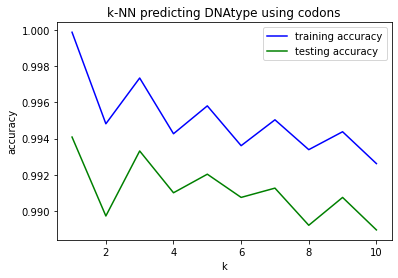

In [14]:
line1, = plt.plot(range(1,11), train_scores, 'b')
line2, = plt.plot(range(1,11), test_scores, 'g')
plt.legend([line1, line2], ['training accuracy', 'testing accuracy'])
plt.title('k-NN predicting DNAtype using codons')
plt.ylabel('accuracy')
plt.xlabel('k')
plt.show()

The overall accuracies given above seem suspiciously high.  I feel like I need to do some kind of model diagnostics.  Let's consider what we get using the aminos instead of the codons.  I also should find a good way to store the testing and training scores.

In [12]:
# this is crude but should do it
knn_dna_codon_train, knn_dna_codon_test = train_scores, test_scores

K = 1 train score: 0.9998897950187349 test score: 0.9922859346875803
K = 2 train score: 0.9905223716111968 test score: 0.9853432759064027
K = 3 train score: 0.9949305708618029 test score: 0.9935716122396503
K = 4 train score: 0.9907427815737271 test score: 0.9915145281563383
K = 5 train score: 0.9933877011240908 test score: 0.9922859346875803
K = 6 train score: 0.9911836014987877 test score: 0.9915145281563383
K = 7 train score: 0.9922856513114393 test score: 0.9930573412188223
K = 8 train score: 0.9899713467048711 test score: 0.9907431216250965
K = 9 train score: 0.9907427815737271 test score: 0.9920287991771664
K = 10 train score: 0.9890897068547498 test score: 0.9889431730521985


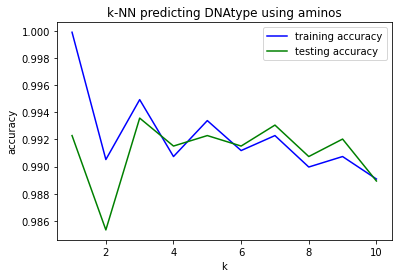

In [15]:
# keeping y as DNAtype, now predicting using aminos
# also integrating all of this stuff into a single cell

X = cu[amino_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13131)
test_scores = []
train_scores = []

for i in range(1,11):

    knn = KNeighborsClassifier(i)
    knn.fit(X_train,y_train)
    
    train_scores.append(knn.score(X_train,y_train))
    test_scores.append(knn.score(X_test,y_test))

for i in range(len(test_scores)):
    print("K =", i+1, "train score:", train_scores[i], "test score:", test_scores[i])

line1, = plt.plot(range(1,11), train_scores, 'b')
line2, = plt.plot(range(1,11), test_scores, 'g')
plt.legend([line1, line2], ['training accuracy', 'testing accuracy'])
plt.title('k-NN predicting DNAtype using aminos')
plt.ylabel('accuracy')
plt.xlabel('k')
plt.show()

knn_dna_amino_train, knn_dna_amino_test = train_scores, test_scores

Again, all of these scores seem very high indeed.  Also note that here, unlike in the preceding case, some of the test scores are higher than the train scores.  This is a sure sign that something has gone glaringly wrong. What's happening here?  What if we try to model the kingdom (rather than DNAtype, as in the preceding instances) using this method?


K = 1 train score: 1.0 test score: 0.9308305476986372
K = 2 train score: 0.9325545514657263 test score: 0.8791463101054255
K = 3 train score: 0.9563588274189994 test score: 0.9177166366675238
K = 4 train score: 0.9203217985452943 test score: 0.8817176652095654
K = 5 train score: 0.9371831606788626 test score: 0.9061455386988944
K = 6 train score: 0.9048931011681728 test score: 0.8794034456158395
K = 7 train score: 0.9197707736389685 test score: 0.8945744407302648
K = 8 train score: 0.8933215781353318 test score: 0.868603754178452
K = 9 train score: 0.9066563808684153 test score: 0.8814605296991515
K = 10 train score: 0.8830725148776725 test score: 0.8608896888660325


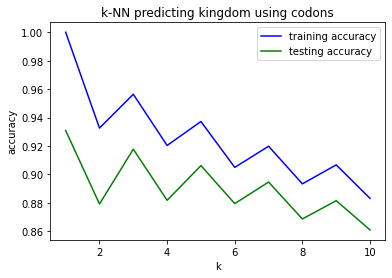

In [16]:
y = cu[kingcols]
X = cu[codon_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=212)

test_scores = []
train_scores = []

for i in range(1,11):

    knn = KNeighborsClassifier(i)
    knn.fit(X_train,y_train)
    
    train_scores.append(knn.score(X_train,y_train))
    test_scores.append(knn.score(X_test,y_test))

for i in range(len(test_scores)):
    print("K =", i+1, "train score:", train_scores[i], "test score:", test_scores[i])
    
line1, = plt.plot(range(1,11), train_scores, 'b')
line2, = plt.plot(range(1,11), test_scores, 'g')
plt.legend([line1, line2], ['training accuracy', 'testing accuracy'])
plt.title('k-NN predicting kingdom using codons')
plt.ylabel('accuracy')
plt.xlabel('k')
plt.show()

knn_king_codon_train, knn_king_codon_test = train_scores, test_scores

This is interesting - these results aren't suspiciously high.  Indeed, the k-NN models applied to kingdom as outcome have scores that look a little weak.  What if we use the codons (instead of aminos) to predict?


K = 1 train score: 1.0 test score: 0.8711751092825919
K = 2 train score: 0.8601498787745206 test score: 0.7850347132939058
K = 3 train score: 0.9083094555873925 test score: 0.8521470815119568
K = 4 train score: 0.8422966718095658 test score: 0.7960915402417074
K = 5 train score: 0.8723826316949526 test score: 0.8351761378246336
K = 6 train score: 0.8240026449195503 test score: 0.7950629982000514
K = 7 train score: 0.8502314304606569 test score: 0.826433530470558
K = 8 train score: 0.8108882521489972 test score: 0.7863203908459758
K = 9 train score: 0.8314965836455808 test score: 0.8079197737207509
K = 10 train score: 0.801410623760194 test score: 0.7791205965543841


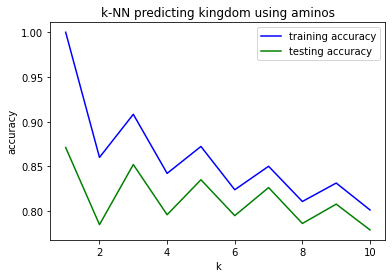

In [17]:
# finally, kingdom on aminos

X = cu[amino_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2102)

test_scores = []
train_scores = []

for i in range(1,11):

    knn = KNeighborsClassifier(i)
    knn.fit(X_train,y_train)
    
    train_scores.append(knn.score(X_train,y_train))
    test_scores.append(knn.score(X_test,y_test))

for i in range(len(test_scores)):
    print("K =", i+1, "train score:", train_scores[i], "test score:", test_scores[i])
    
line1, = plt.plot(range(1,11), train_scores, 'b')
line2, = plt.plot(range(1,11), test_scores, 'g')
plt.legend([line1, line2], ['training accuracy', 'testing accuracy'])
plt.title('k-NN predicting kingdom using aminos')
plt.ylabel('accuracy')
plt.xlabel('k')
plt.show()

knn_king_amino_train, knn_king_amino_test = train_scores, test_scores

Interestingly, I'm not seeing the same problems when fitting kNN to model 'kingdom' that I did modeling 'DNAtype' - what explains this?  If there were some problem with the train test split, or normalization, wouldn't it impact both sets of models?  This is something that I really need to explain.

## Random Forest

I'm going to start with a single random forest model, and assess feature importance.

In [41]:
y = cu[dnacols]
X = cu[codon_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13013)

rfc = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = rfc.fit(X_train, y_train)
y_pred = model_res.predict(X_test)

ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')


print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.986
Random Forest: f1-score=0.989


30


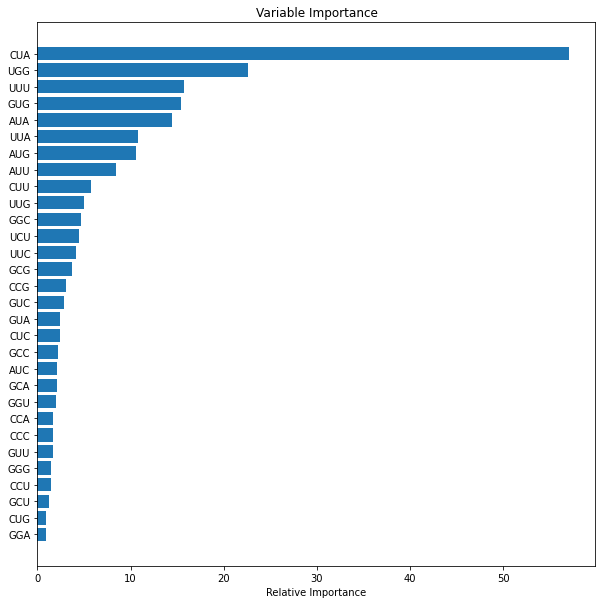

In [42]:
feature_importance = rfc.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Random Forest: Accuracy=0.985
Random Forest: f1-score=0.987
22


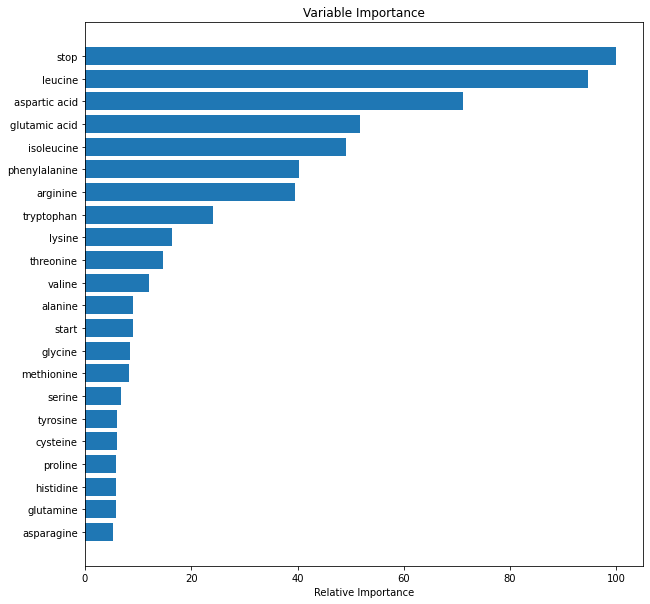

In [43]:
y = cu[dnacols]
X = cu[amino_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1863)

rfc = RandomForestClassifier(n_estimators=300, random_state = 531,n_jobs=-1)
model_res = rfc.fit(X_train, y_train)
y_pred = model_res.predict(X_test)

ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')


print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

feature_importance = rfc.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

n_estimators: 200 train score: 0.9998897950187349 test score: 0.9861146824376447
n_estimators: 220 train score: 0.9998897950187349 test score: 0.9858575469272306
n_estimators: 240 train score: 0.9998897950187349 test score: 0.9861146824376447
n_estimators: 260 train score: 0.9998897950187349 test score: 0.9858575469272306
n_estimators: 280 train score: 0.9998897950187349 test score: 0.9858575469272306
n_estimators: 300 train score: 0.9998897950187349 test score: 0.9856004114168166
n_estimators: 320 train score: 0.9998897950187349 test score: 0.9856004114168166
n_estimators: 340 train score: 0.9998897950187349 test score: 0.9856004114168166
n_estimators: 360 train score: 0.9998897950187349 test score: 0.9861146824376447
n_estimators: 380 train score: 0.9998897950187349 test score: 0.9858575469272306
n_estimators: 400 train score: 0.9998897950187349 test score: 0.9858575469272306


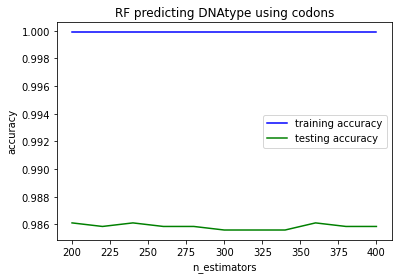

In [33]:
# ok, let's try iterating over some values for n_estimators
# (here, y=DNAtype and X=codons)

test_scores = []
train_scores = []

for i in range(11):
    
    rfc = RandomForestClassifier(n_estimators=200+20*i, random_state = 1,n_jobs=-1)
    rfc.fit(X_train,y_train)
    
    train_scores.append(rfc.score(X_train,y_train))
    test_scores.append(rfc.score(X_test,y_test))

for i in range(len(test_scores)):
    print("n_estimators:", 200+20*i, "train score:", train_scores[i], "test score:", test_scores[i])

    
xl = list(range(200, 401, 20))
line1, = plt.plot(xl, train_scores, 'b')
line2, = plt.plot(xl, test_scores, 'g')
plt.legend([line1, line2], ['training accuracy', 'testing accuracy'])
plt.title('RF predicting DNAtype using codons')
plt.ylabel('accuracy')
plt.xlabel('n_estimators')
plt.show()

rf_dna_codon_train, rf_dna_codon_test = train_scores, test_scores
    

Interestingly, we have nearly perfect training accuracy across all values of n_estimators.  Testing accuracy is also very high, but slightly variable.

n_estimators: 200 train score: 1.0 test score: 0.9848290048855747
n_estimators: 220 train score: 1.0 test score: 0.9845718693751607
n_estimators: 240 train score: 1.0 test score: 0.9843147338647468
n_estimators: 260 train score: 1.0 test score: 0.9843147338647468
n_estimators: 280 train score: 1.0 test score: 0.9843147338647468
n_estimators: 300 train score: 1.0 test score: 0.9845718693751607
n_estimators: 320 train score: 1.0 test score: 0.9845718693751607
n_estimators: 340 train score: 1.0 test score: 0.9845718693751607
n_estimators: 360 train score: 1.0 test score: 0.9845718693751607
n_estimators: 380 train score: 1.0 test score: 0.9843147338647468
n_estimators: 400 train score: 1.0 test score: 0.9840575983543327


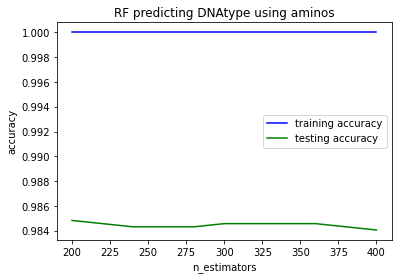

In [35]:
# still predicting DNAtype, now using aminos

X = cu[amino_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=608)


test_scores = []
train_scores = []

for i in range(11):
    
    rfc = RandomForestClassifier(n_estimators=200+20*i, random_state = 31,n_jobs=-1)
    rfc.fit(X_train,y_train)
    
    train_scores.append(rfc.score(X_train,y_train))
    test_scores.append(rfc.score(X_test,y_test))

for i in range(len(test_scores)):
    print("n_estimators:", 200+20*i, "train score:", train_scores[i], "test score:", test_scores[i])

    
xl = list(range(200, 401, 20))
line1, = plt.plot(xl, train_scores, 'b')
line2, = plt.plot(xl, test_scores, 'g')
plt.legend([line1, line2], ['training accuracy', 'testing accuracy'])
plt.title('RF predicting DNAtype using aminos')
plt.ylabel('accuracy')
plt.xlabel('n_estimators')
plt.show()

rf_dna_amino_train, rf_dna_amino_test = train_scores, test_scores

The same phenomenon.  I'm suspecting this will be the same in the remaining two cases.


n_estimators: 200 train score: 1.0 test score: 0.7410645410131139
n_estimators: 220 train score: 1.0 test score: 0.7413216765235279
n_estimators: 240 train score: 1.0 test score: 0.740293134481872
n_estimators: 260 train score: 1.0 test score: 0.7405502699922859
n_estimators: 280 train score: 1.0 test score: 0.7410645410131139
n_estimators: 300 train score: 1.0 test score: 0.7405502699922859
n_estimators: 320 train score: 1.0 test score: 0.7418359475443559
n_estimators: 340 train score: 1.0 test score: 0.7428644895860118
n_estimators: 360 train score: 1.0 test score: 0.7423502185651839
n_estimators: 380 train score: 1.0 test score: 0.7418359475443559
n_estimators: 400 train score: 1.0 test score: 0.7431216250964258


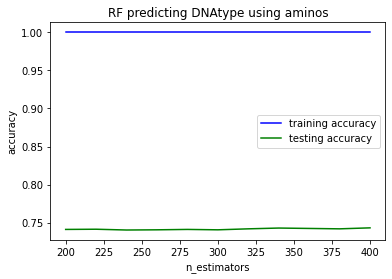

In [37]:
# predicting kingdom using codons

y = cu[kingcols]
X = cu[codon_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13013)


test_scores = []
train_scores = []

for i in range(11):
    
    rfc = RandomForestClassifier(n_estimators=200+20*i, random_state = 31,n_jobs=-1)
    rfc.fit(X_train,y_train)
    
    train_scores.append(rfc.score(X_train,y_train))
    test_scores.append(rfc.score(X_test,y_test))

for i in range(len(test_scores)):
    print("n_estimators:", 200+20*i, "train score:", train_scores[i], "test score:", test_scores[i])

    
xl = list(range(200, 401, 20))
line1, = plt.plot(xl, train_scores, 'b')
line2, = plt.plot(xl, test_scores, 'g')
plt.legend([line1, line2], ['training accuracy', 'testing accuracy'])
plt.title('RF predicting DNAtype using aminos')
plt.ylabel('accuracy')
plt.xlabel('n_estimators')
plt.show()

rf_king_codon_train, rf_king_codon_test = train_scores, test_scores

n_estimators: 200 train score: 1.0 test score: 0.7076369246592954
n_estimators: 220 train score: 1.0 test score: 0.7073797891488814
n_estimators: 240 train score: 1.0 test score: 0.7073797891488814
n_estimators: 260 train score: 1.0 test score: 0.7071226536384675
n_estimators: 280 train score: 1.0 test score: 0.7081511956801234
n_estimators: 300 train score: 1.0 test score: 0.7066083826176395
n_estimators: 320 train score: 1.0 test score: 0.7073797891488814
n_estimators: 340 train score: 1.0 test score: 0.7076369246592954
n_estimators: 360 train score: 1.0 test score: 0.7078940601697095
n_estimators: 380 train score: 1.0 test score: 0.7089226022113654
n_estimators: 400 train score: 1.0 test score: 0.7076369246592954


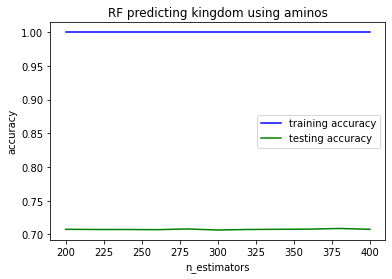

In [38]:
# predicting kingdom using aminos

X = cu[amino_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13013)

test_scores = []
train_scores = []

for i in range(11):
    
    rfc = RandomForestClassifier(n_estimators=200+20*i, random_state = 31,n_jobs=-1)
    rfc.fit(X_train,y_train)
    
    train_scores.append(rfc.score(X_train,y_train))
    test_scores.append(rfc.score(X_test,y_test))

for i in range(len(test_scores)):
    print("n_estimators:", 200+20*i, "train score:", train_scores[i], "test score:", test_scores[i])

    
xl = list(range(200, 401, 20))
line1, = plt.plot(xl, train_scores, 'b')
line2, = plt.plot(xl, test_scores, 'g')
plt.legend([line1, line2], ['training accuracy', 'testing accuracy'])
plt.title('RF predicting kingdom using aminos')
plt.ylabel('accuracy')
plt.xlabel('n_estimators')
plt.show()

rf_king_amino_train, rf_king_amino_test = train_scores, test_scores

The only difference seems to be that, when predicting kingdom as opposed to DNAtype, the testing accuracy drops substantially.  In all cases, the uniformly high training accuracy is suspicious.  I suspect that I'll need to adjust some other parameters for the Random Forest classifier in order to  produce a model that's actually useful.

## XGBoost


In [45]:
# having never used the XGBoost classifier before, I will start with a naive instance
y = cu[dnacols]
X = cu[codon_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13013)

xgb = xg.XGBClassifier()
xgb.fit(X_train, y_train)
print(xgb)


C:\Users\null\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


ValueError: y should be a 1d array, got an array of shape (9074, 3) instead.

Based on the warning and the ValueError, I'm going to surmise that the encoding of response variables is unneeded and indeed unworkable for the XGBoost classifier, and I'm going to need to incorporate the original 'DNAtype' and 'kingdom' variables that I started with.  **I had to go back and edit the preprocessing notebook so as not to delete these variables in the first place.**

In [60]:
# trying again:  DNAtype on codon_list

y = cu['DNAtype']
X = cu[codon_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13013)

xgb = xg.XGBClassifier()
xgb.fit(X_train, y_train)
print(xgb)


C:\Users\null\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:22:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [62]:
y_pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 99.05%


Apparently this worked - although, obviously, hyperparameter tuning remains a pretty big deal here.

In [63]:
# XGBoost:  DNAcols predicted by aminos

y = cu['DNAtype']
X = cu[amino_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=19044)

xgb = xg.XGBClassifier()
xgb.fit(X_train, y_train)
print(xgb)

y_pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

C:\Users\null\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:30:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
Accuracy: 99.31%


In [64]:
# XGBoost:  kingdom predicted by codons

y = cu['Kingdom']
X = cu[codon_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=19044)

xgb = xg.XGBClassifier()
xgb.fit(X_train, y_train)
print(xgb)

y_pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

C:\Users\null\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:31:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
Accuracy: 92.44%


In [65]:
# XGBoost:  kingdom predicted by aminos

y = cu['DNAtype']
X = cu[amino_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=19044)

xgb = xg.XGBClassifier()
xgb.fit(X_train, y_train)
print(xgb)

y_pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

C:\Users\null\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:32:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
Accuracy: 99.31%


I don't know what to get out of this.  At least I got XGBoost to work; there are so many hyperparameters, though, that I'm not sure how to go about tuning them.  Nor am I sure how to evaluate these models, other than by such metrics as accuracy, F1, etc.